In [1]:
import torch
torch.cuda.empty_cache()


In [2]:
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [3]:
torch.set_float32_matmul_precision('medium')


In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:5000"



In [5]:

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [6]:
#General libraries
import os, argparse
import pickle

import numpy as np

#Torch libraries
import torch 
from torch import nn

#Custom libraries
from IE_source.utils import Segmentation_Dataset
from utils import fix_random_seeds,to_np
import IE_source.kernels as kernels
from IE_source.experiments import Crack_experiment
from torch.utils.data import SubsetRandomSampler
from IE_source.kernels import model_blocks
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline


if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
    

parser = argparse.ArgumentParser(description='Neural IE')
parser.add_argument('-root_path', metavar='DIR', default='',
                    help='path to dataset')
parser.add_argument('-dataset-name', default='stl10',
                    help='dataset name', choices=['acrobot_dataset'])

parser.add_argument('-j', '--workers', default=12, type=int, metavar='N',
                    help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=3000, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch_size', default=20, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--fp16-precision', action='store_true',
                    help='Whether or not to use 16-bit precision GPU training.')

parser.add_argument('--out_dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--log-every-n-steps', default=100, type=int,
                    help='Log every n steps')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')
parser.add_argument('--n-views', default=2, type=int, metavar='N',
                    help='Number of views for contrastive learning training.')
parser.add_argument('--gpu-index', default=0, type=int, help='Gpu index.')
parser.add_argument('--model', default='simclr', choices=['simclr','lipschitz_simclr','vae','gan'], 
                    help='Models to be used')
parser.add_argument('--mode', default='train', choices=['train','evaluate'], 
                    help='Set to ''evaluate'' if inference is desired')
parser.add_argument('--training_split', default=0.25,type=float, 
                    help='Fraction of the samples that will be used for validation')
parser.add_argument('--resume_from_checkpoint', default=None, 
                    help='Give string to run number. Ex: "run12"')
parser.add_argument('--plot_freq', default=1, type=int,help='')
parser.add_argument('--experiment_name', default=None,help='')

 


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


_StoreAction(option_strings=['--experiment_name'], dest='experiment_name', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='', metavar=None)

In [7]:
'''
args.mode='train' to train the model, and args.mode='evaluate' for testing.
args.resume_from_checkpoint='run#' allows to load the model used for run#
to resume training or for testing it.
'''
args = parser.parse_args("")
args.model='nie'
args.mode='train'
#args.mode = 'evaluate'
args.dataset_name = 'integral_equations'
args.seed = 7
args.experiment_name = 'Crack_segmentation'
args.plot_freq = 10
args.device = device
args.num_dim_plot = 2
args.lr = 1e-4
args.min_lr=1e-9
args.T_max = 30
args.plat_patience = 10
args.factor = 0.5
# args.lr_scheduler = 'ReduceLROnPlateau'
args.lr_scheduler = 'CosineAnnealingLR'
#args.resume_from_checkpoint = 'run317'
fix_random_seeds(args.seed)
args.perturbation_to_obs0=None
args.training_split=0.2
args.smoothing_factor=.5
args.patience_stopping = 1000

In [8]:
args.kernel_split = True
args.free_func_nn = False
args.kernel_type_nn = True
args.G_NN = True
args.num_internal_points = 100 
args.plot_F_func = False
args.f_nn = False
args.max_iterations=3
args.sampling_points=100 
args.time_points= 1 
args.support_tensors=False
args.support_test=False 
args.test_points=40  
args.combine_points=False
args.patches=True
args.initialization=False
args.alpha=0.6

In [9]:
if args.mode=='train':
    args.initial_t=True
else:
    args.initial_t=False 

In [10]:
# args.dim = 16
# args.dim_emb = 32
# args.n_head = 2
# args.n_blocks = 2
# args.n_ff = 64
# args.attention_type = 'galerkin'
# args.final_block = False
# args.dim_out =args.dim

In [11]:
# # '''
# # Architecture of the transformer used for quadrature of the integrals.
# #  '''

args.dim =32
args.dim_emb=64
args.n_head=4
args.n_blocks=4
args.n_ff=128
args.attention_type='galerkin'
args.final_block=False
args.dim_out= args.dim

In [12]:
import matplotlib.pyplot as plt

In [13]:
import scipy.io as spio

In [14]:
import mat73

In [15]:

Eqn_type = 'Navier-Stokes'

In [16]:
Data = "/lfs/koraskoirala.isu/ANIE/Cracked_Images"
masks = "/lfs/koraskoirala.isu/ANIE/Cracked_masks"

# Load your pre-stacked dataset here
images_tensor, masks_tensor = ("Cracked_Images", "Cracked_masks")
Data = {'images': images_tensor, 'masks': masks_tensor}  # Save them as a dictionary




In [17]:

# Load the saved tensors
images_tensor = torch.load("Cracked_Images_resized.pt")
masks_tensor = torch.load("Cracked_masks_resized.pt")


# Print their shapes
print(images_tensor.shape)  # Expected: (num_samples, channels, height, width)
print(masks_tensor.shape)   # Expected: (num_samples, channels, height, width) or (num_samples, height, width)



torch.Size([9887, 3, 256, 256])
torch.Size([9887, 256, 256])


In [18]:
Data

{'images': 'Cracked_Images', 'masks': 'Cracked_masks'}

In [19]:
import torch

In [20]:
Data.keys()

dict_keys(['images', 'masks'])

In [21]:
# import torch
# from torchvision import transforms
# from torchvision.transforms.functional import to_pil_image
# from tqdm import tqdm

# def resize_tensor_dataset(images_tensor, masks_tensor, new_size=(256, 256)):
#     resized_images = []
#     resized_masks = []

#     for i in tqdm(range(len(images_tensor))):
#         image = images_tensor[i].permute(2, 0, 1)  # (H, W, C) → (C, H, W)
#         mask = masks_tensor[i].squeeze(-1)         # (H, W, 1) → (H, W)

#         image_pil = to_pil_image(image)
#         mask_pil = to_pil_image(mask.byte())       # make sure it's uint8 for mask

#         resized_image = transforms.ToTensor()(transforms.Resize(new_size)(image_pil))
#         resized_mask = transforms.PILToTensor()(transforms.Resize(new_size, interpolation=transforms.InterpolationMode.NEAREST)(mask_pil))

#         resized_images.append(resized_image)
#         resized_masks.append(resized_mask.squeeze(0).long())

#     resized_images_tensor = torch.stack(resized_images)
#     resized_masks_tensor = torch.stack(resized_masks)

#     return resized_images_tensor, resized_masks_tensor


In [22]:
# resized_images, resized_masks = resize_tensor_dataset(images_tensor, masks_tensor, new_size=(256, 256))

# # # Optional: Save to disk
# # torch.save(resized_images, 'Cracked_Images_resized.pt')
# # torch.save(resized_masks, 'Cracked_masks_resized.pt')

# # Confirm shape
# print(resized_images.shape)  # should be [9887, 3, 256, 256]
# print(resized_masks.shape)   # should be [9887, 256, 256]


In [23]:
'''
This creates the grid for the images.
'''
t_max = 1 
t_min = 0
n_points = 64

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack(index_np[:, None])
times_np = np.linspace(t_min, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])


###########################################################
times = torch.from_numpy(times_np[:, :, None]).to(device)
times = times.flatten().float()

###########################################################
args.time_interval=t_min, t_max

In [24]:
print(images_tensor.shape)  # For image tensor
print(masks_tensor.shape)   # For mask tensor


torch.Size([9887, 3, 256, 256])
torch.Size([9887, 256, 256])


Shape of image_0: torch.Size([3, 256, 256])
Shape of mask_0: torch.Size([256, 256])


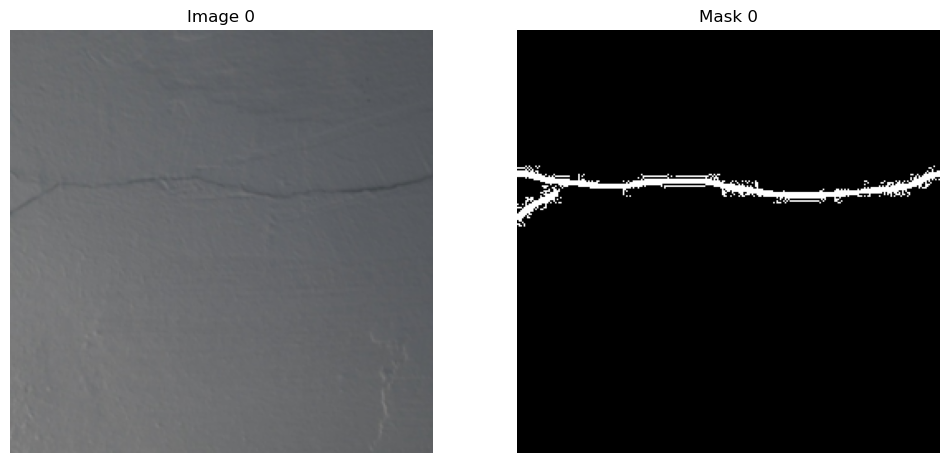

Shape of image_1: torch.Size([3, 256, 256])
Shape of mask_1: torch.Size([256, 256])


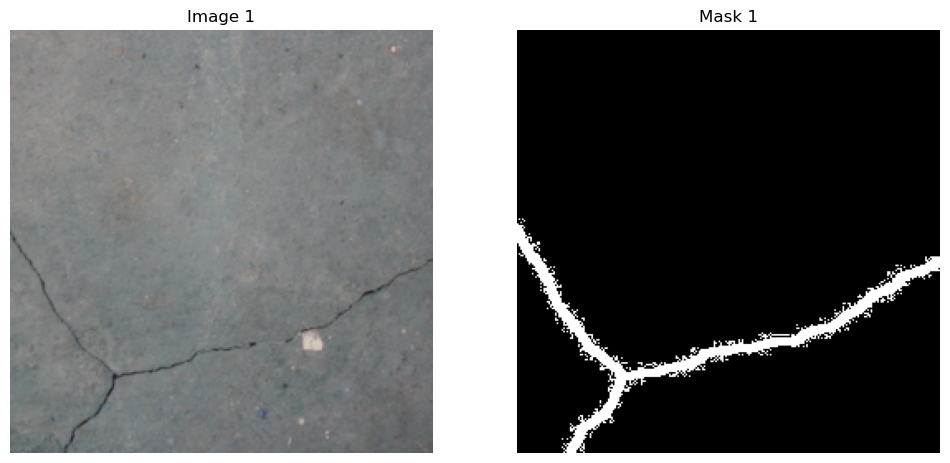

Shape of image_2: torch.Size([3, 256, 256])
Shape of mask_2: torch.Size([256, 256])


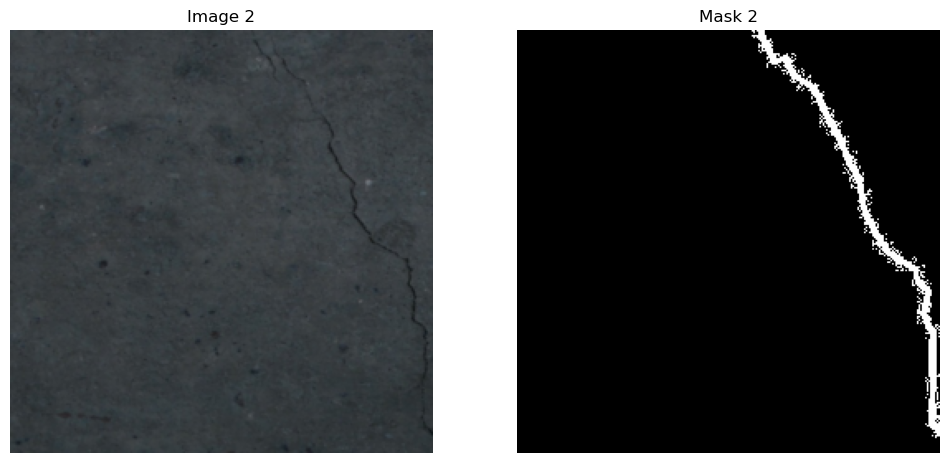

Shape of image_3: torch.Size([3, 256, 256])
Shape of mask_3: torch.Size([256, 256])


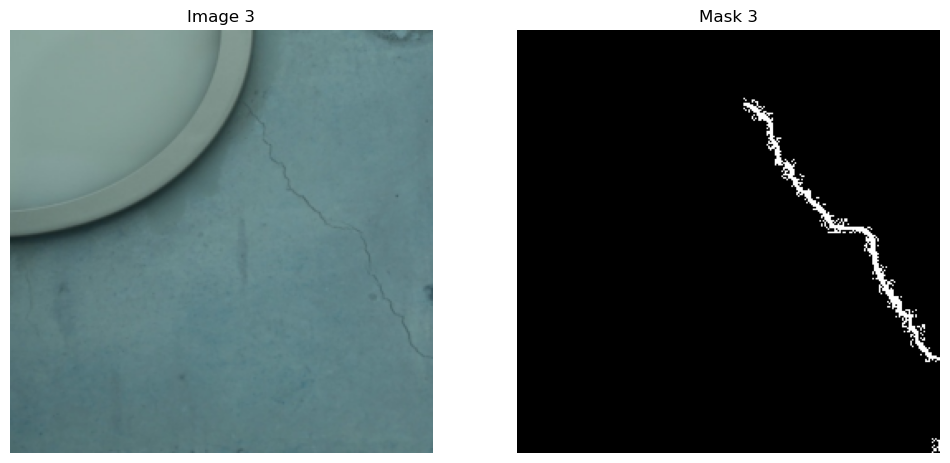

Shape of image_4: torch.Size([3, 256, 256])
Shape of mask_4: torch.Size([256, 256])


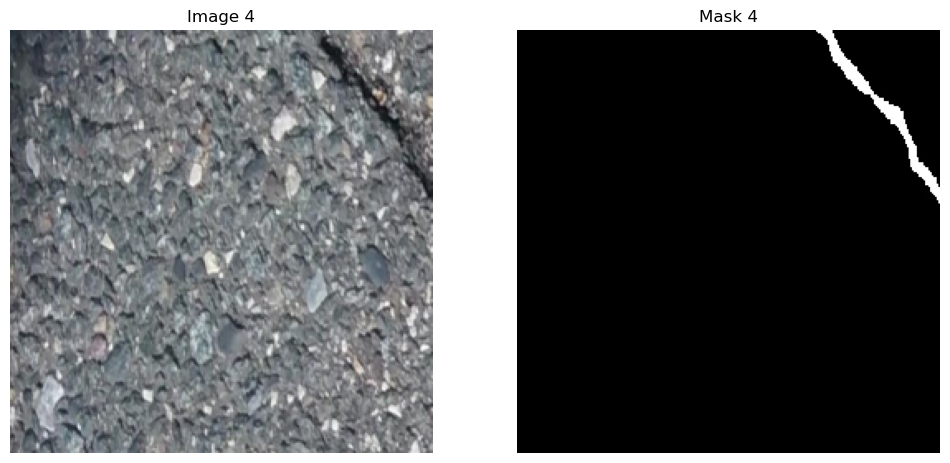

Shape of image_5: torch.Size([3, 256, 256])
Shape of mask_5: torch.Size([256, 256])


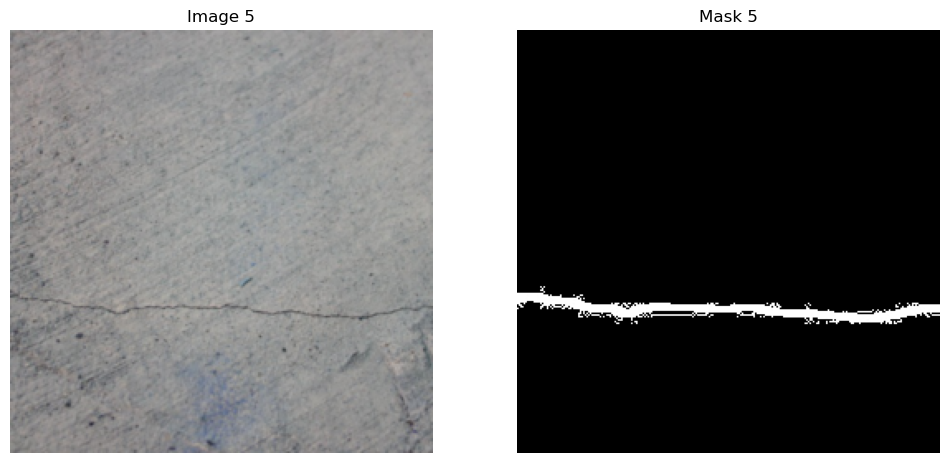

Shape of image_6: torch.Size([3, 256, 256])
Shape of mask_6: torch.Size([256, 256])


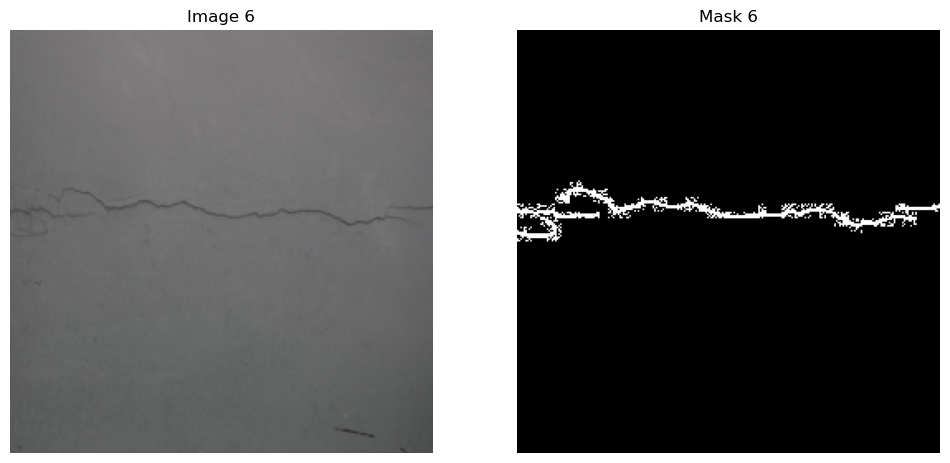

Shape of image_7: torch.Size([3, 256, 256])
Shape of mask_7: torch.Size([256, 256])


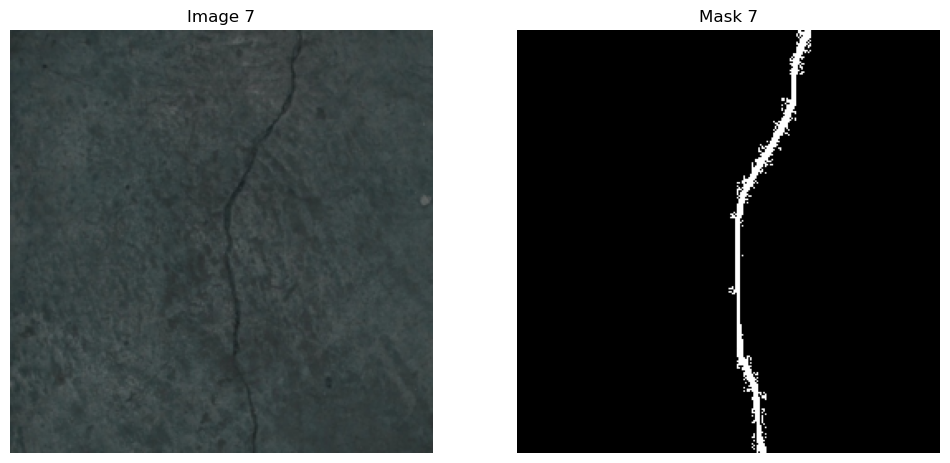

Shape of image_8: torch.Size([3, 256, 256])
Shape of mask_8: torch.Size([256, 256])


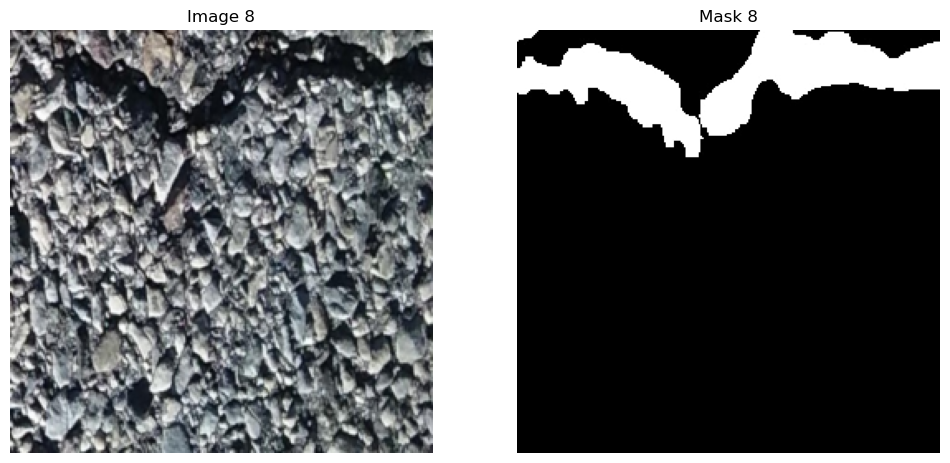

Shape of image_9: torch.Size([3, 256, 256])
Shape of mask_9: torch.Size([256, 256])


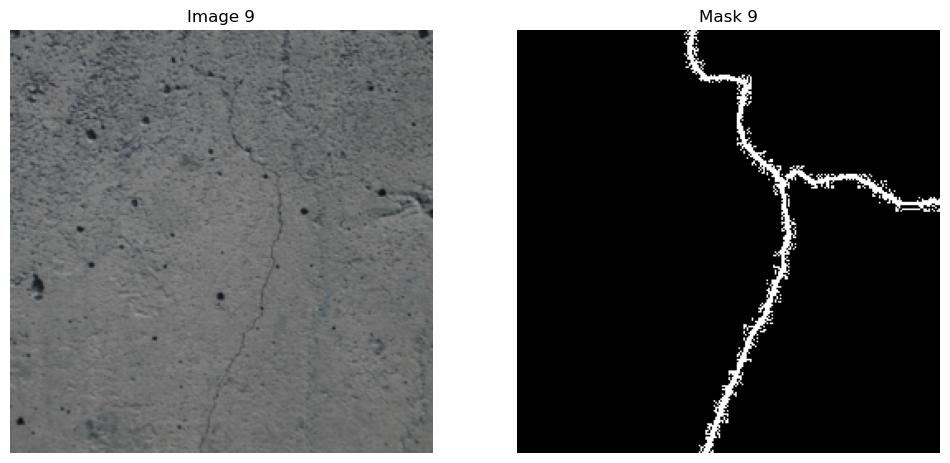

In [25]:
# Plot some of the data to visualize it
for i in range(10):
    # Access the image and mask tensors
    image = images_tensor[i]  # Shape: (3, 256, 256)
    mask = masks_tensor[i].squeeze()  # Shape: (256, 256)

    # Print the shapes for debugging
    print(f"Shape of image_{i}: {image.shape}")
    print(f"Shape of mask_{i}: {mask.shape}")
    
    # Convert image to (H, W, C) for matplotlib
    image_np = image.permute(1, 2, 0).numpy()
    
    # Plot image and mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(image_np)
    axes[0].set_title(f"Image {i}")
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title(f"Mask {i}")
    axes[1].axis('off')
    
    plt.show()



     
       

In [26]:
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

In [27]:
Data = images_tensor

In [28]:
# Original Data shape: [B, C, H, W]
Data = Data.permute(0, 2, 3, 1)         # → [B, H, W, C]
Data = Data.unsqueeze(3).to(device)             # → [B, H, W, 1, C]


In [29]:
Data = Data.to(device)

In [30]:
Data.shape

torch.Size([9887, 256, 256, 1, 3])

In [31]:
Data = Data.float()

In [32]:
ids = np.tile(np.linspace(0,Data.shape[1]-1,num=n_points, dtype=np.int64),(Data.shape[1],1))

In [33]:
ids[0]

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 170, 174, 178, 182, 186, 190, 194, 198, 202, 206,
       210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 255])

In [34]:
t_ids = np.tile(np.linspace(0,Data.shape[-1]-1,num=args.time_points, dtype=np.int64),(Data.shape[-1],1))

In [35]:
t_ids[0]

array([0])

In [36]:
'''
Integration interval.
'''
ts_integration = torch.linspace(0,1,Data.shape[-1])
ts_integration = ts_integration[t_ids[0]]
print(ts_integration)
args.ts_integration = ts_integration

tensor([0.])


In [37]:

# '''
# Downsample time points and spatial resolution.
# '''
# if Eqn_type=='Burgers':
#     Data = Data[:,ids[0],:]
# else:
#     Data = Data[:,ids[0],:,:]
#     Data = Data[:,:,ids[0],:]
#     Data = Data[:,:,:,t_ids[0]]
#     #Data = Data[:,:,:,:args.time_points]

In [38]:
Data.shape

torch.Size([9887, 256, 256, 1, 3])

In [39]:
# Data = Data[:4500]
# masks_tensor = masks_tensor[:4500]

In [40]:
# flattened=masks_tensor.flatten()
# # Count class frequencies
# num_class_0 = torch.sum(flattened == 0).item()
# num_class_1 = torch.sum(flattened == 1).item()
# total = num_class_0 + num_class_1

# # Compute inverse frequency class weights
# weight_0 = total / (2 * num_class_0 + 1e-8)
# weight_1 = total / (2 * num_class_1 + 1e-8)
# class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float32)



In [41]:
# class_weights

In [42]:
# args.class_weights=class_weights

In [43]:
#args.range_imshow = np.array([np.quantile(to_np(Data).flatten(), 0.15), np.quantile(to_np(Data).flatten(), 0.85)])#np.array([-0.25,0.05])


In [44]:
#args.range_imshow

In [45]:
# # Remove the extra dimension (dim=3)
# Data = Data.squeeze(3)
# print("After squeeze:", Data.shape)  # should be [2500, 448, 448, 3]



In [46]:
# import torch
# import torch.nn.functional as F

# Data = Data.squeeze(3)

# # Permute to [batch, channels, height, width]
# Data = Data.permute(0, 3, 1, 2)

# # Interpolate to smaller size
# Data = F.interpolate(Data, size=(256, 256), mode='bilinear', align_corners=False)

# # Check final shape
# print("New Data shape:", Data.shape)


In [47]:
# # Step 1: Squeeze the last dim → [2500, 448, 448]
# masks_tensor = masks_tensor.squeeze(-1)

# # Step 2: Add channel dim at dim=1 → [2500, 1, 448, 448]
# masks_tensor = masks_tensor.unsqueeze(1).float()

# # Step 3: Interpolate → [2500, 1, 256, 256]
# masks_tensor = F.interpolate(masks_tensor, size=(256, 256), mode='trilinear', align_corners=False)

# # Step 4: Squeeze back → [2500, 256, 256]
# masks_tensor = masks_tensor.squeeze(1).long()

# # Final shape check
# print("New masks_tensor shape:", masks_tensor.shape)


In [48]:
'''
Initialize model and dataset.
'''
n_steps = 100  # Adjust as needed
print('Data.shape: ', Data.shape)



args.batch_size = 32



Data = Data.to(device)
masks_tensor = masks_tensor.to(device)

masks_tensor = (masks_tensor >= 0.5).int()


Dataset_train = Segmentation_Dataset(Data[:-600], masks_tensor[:-600], augment=True)
Dataset_val = Segmentation_Dataset(Data[-600:-300], masks_tensor[-600:-300], augment=False)
Dataset_test = Segmentation_Dataset(Data[-300:], masks_tensor[-300:], augment=False)


# Create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(Dataset_train, batch_size=args.batch_size, drop_last=True,shuffle=True ),
    'val': torch.utils.data.DataLoader(Dataset_val, batch_size=args.batch_size, drop_last=True),
    'test': torch.utils.data.DataLoader(Dataset_test, batch_size= args.batch_size),
}

# Initialize the model
model = model_blocks(args.dim+2,
                     args.dim_emb,
                     args.n_head,
                     args.n_blocks,
                     args.n_ff,
                     args.attention_type,
                     args.dim_out,
                     args.final_block,
                     dropout=0.2)

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()


Data.shape:  torch.Size([9887, 256, 256, 1, 3])


In [49]:
print('masks_tensor shape:', masks_tensor.shape)
print('Unique mask values:', masks_tensor.unique())


masks_tensor shape: torch.Size([9887, 256, 256])
Unique mask values: tensor([0, 1], device='cuda:0', dtype=torch.int32)


In [50]:
# import numpy as np
# import torch

# flattened = masks_tensor.flatten().cpu().numpy()
# num_class_0 = np.sum(flattened == 0)
# num_class_1 = np.sum(flattened == 1)

# w0 = 1.0 / (np.sqrt(num_class_0) + 1e-8)
# w1 = 1.0 / (np.sqrt(num_class_1) + 1e-8)

# # Boost the minority class
# boost = 3.0
# if num_class_0 < num_class_1:
#     w0 *= boost
# else:
#     w1 *= boost

# # Normalize
# sum_w = w0 + w1
# weights = [w0 / sum_w, w1 / sum_w]

# class_weights = torch.tensor(weights, dtype=torch.float32).to(masks_tensor.device)
# args.class_weights = class_weights



In [51]:
import numpy as np
import torch

# Count class occurrences
flattened = masks_tensor.flatten().cpu().numpy()
num_class_0 = np.sum(flattened == 0)
num_class_1 = np.sum(flattened == 1)

# Soften the weights using square root of inverse frequency
w0 = 1.0 / (np.sqrt(num_class_0) + 1e-8)
w1 = 1.0 / (np.sqrt(num_class_1) + 1e-8)

# Normalize so sum to 1 (optional but recommended)
sum_w = w0 + w1
weights = [w0 / sum_w, w1 / sum_w]

# Convert to torch tensor and move to device
class_weights = torch.tensor(weights, dtype=torch.float32).to(masks_tensor.device)
args.class_weights = class_weights


In [52]:
class_weights

tensor([0.1827, 0.8173], device='cuda:0')

In [53]:
print('Data min:', Data.min().item())
print('Data max:', Data.max().item())


Data min: 0.0
Data max: 1.0


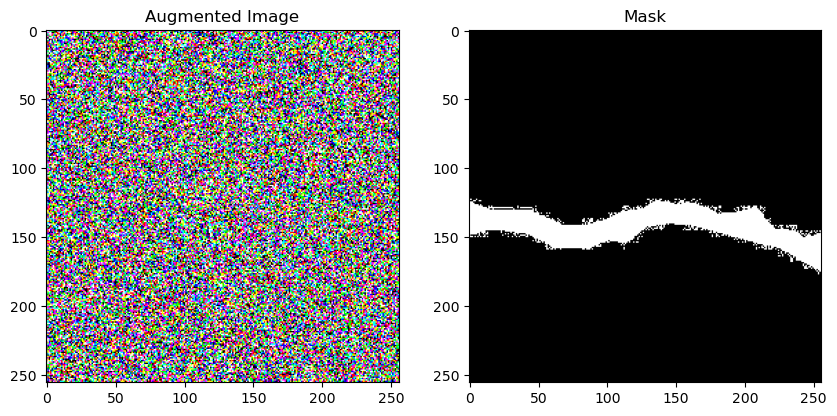

In [54]:
import matplotlib.pyplot as plt

idx = 1000
image, mask = Dataset_train[idx]

# Fix shape: [H, W, 1, 3] → [H, W, 3]
image = image.squeeze(2)

# Convert to numpy for plotting
image_np = image.cpu().numpy()
mask_np = mask.cpu().numpy()

# Normalize image for visualization (0–1 range)
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)

# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_np)
plt.title("Augmented Image")

plt.subplot(1,2,2)
plt.imshow(mask_np, cmap='gray')
plt.title("Mask")

plt.show()


In [55]:
exp_mode = 'Fredholm'

In [56]:
#Fredholm mode
mask = None

In [57]:
#Volterra mode
if exp_mode == 'Volterra':
    masking_map =  masking_function(lambda x: 0.,lambda x: x,n_batch=1)
    mask_times = times
    mask = masking_map.create_mask(mask_times)

In [58]:
args.n_patch = 8 

In [59]:
# Encoder = kernels.SingleConvNeuralNet(
#     3,
#     args.dim,
#     args.dim,
#     K=[4,4],  #88,44
#     S=[2,2]
# )

In [60]:
Encoder = kernels.DualConvConcatNet(
    dim=3,                 # input channels
    hidden_dim=args.dim,   # for each branch
    out_dim=args.dim,      # final output channels
    K1=[4, 4],             # kernel for branch 1
    S1=[2, 2],             # stride for branch 1
    K2=[4, 4],             # kernel for branch 2
    S2=[2, 2]              # stride for branch 2
)

In [61]:
if torch.cuda.is_available():
    Encoder = Encoder.cuda()

In [62]:
Data.shape

torch.Size([9887, 256, 256, 1, 3])

In [63]:
# # Encoder already on correct device
# # x = Data[:4, :, :, 0, :].permute(0, 3, 1, 2).to(args.device)  # [B, C, H, W]
# # args.shapes = Encoder(x).squeeze(3).shape  # [B, H, W, C]
# x = Data[:4, :, :, 0, :]  # shape: [4, 256, 256, 3]
# # No permute here
# args.shapes = Encoder(x).squeeze(3).shape


In [64]:
# Make sure the Encoder is on the correct device
Encoder = Encoder.to(args.device)

# Extract a small batch from the data and format it
x = Data[:4, :, :, 0, :].permute(0, 3, 1, 2)  # shape: [4, C, H, W]

# Move the input to the same device as the Encoder
x = x.to(args.device)

# Pass through the encoder to get output shape
args.shapes = Encoder(x).shape


In [65]:
args.shapes

torch.Size([4, 32, 128, 128])

In [66]:
args.n_points= args.shapes[-1]

In [67]:
# Decoder = kernels.Decoder_NN_2D(args.dim*args.shapes[-1]*args.shapes[-2],2*256**2,[65,65],[256,256,2])

In [68]:
# Import the new decoder 
from IE_source.improved_decoder import UNetDecoder_2D

Decoder = UNetDecoder_2D(
    in_channels=args.dim,    
    n_classes=2,         # Background + Crack
    bilinear=True,       # Use bilinear upsampling (faster, stable)
    feature_channels=[64, 32, 16]  # Decoder stages
)

In [69]:
#  Decoder = kernels.Decoder_NN_2D(
#      args.shapes[1] * args.shapes[2] * args.shapes[3],
#      2 * 256 * 256,
#      [128,128],
#     [256, 256, 2],
# )


In [70]:
args.dim

32

In [71]:
 # Decoder((torch.rand(4,args.shapes[2],args.shapes[3],args.shapes[1]))).shape

In [72]:
# x = torch.rand(4, 128, 128, 16)  # [B, H, W, C]
# out = Decoder(x)
# print(out.shape)  # Should be [4, 256, 256, 2]


In [73]:
if torch.cuda.is_available():
    Decoder = Decoder.cuda()

In [74]:
args.epochs=5000

In [75]:
args.eqn_type = Eqn_type

In [76]:
# Check your main device
print(f"Using device: {args.device}")

# Check if model components are on the correct device
print(f"Encoder device: {next(Encoder.parameters()).device}")
print(f"Decoder device: {next(Decoder.parameters()).device}")
print(f"Main model device: {next(model.parameters()).device}")

# Check if Data and Masks are on correct device
print(f"Data device: {Data.device}")
print(f"Masks tensor device: {masks_tensor.device}")

# Optional: check a sample batch from the dataloader
sample_batch = next(iter(dataloaders['val']))
print(f"Batch image device: {sample_batch[0].device}")
print(f"Batch mask device: {sample_batch[1].device}")



Using device: cuda:0
Encoder device: cuda:0
Decoder device: cuda:0
Main model device: cuda:0
Data device: cuda:0
Masks tensor device: cuda:0
Batch image device: cuda:0
Batch mask device: cuda:0


In [ ]:
Crack_experiment(model,Encoder,Decoder,dataloaders, times, index_np, mask, times, args, extrapolation_points=None)

/lfs/koraskoirala.isu/miniconda3/envs/DIC/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


path_to_experiment:  nie/Crack_segmentation
Epoch: 0


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:03<15:09,  3.15s/it]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:04<08:39,  1.80s/it]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 


Best validation loss: 0.675185845957862
Saving best model for epoch: 1

Epoch: 1


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:00<03:49,  1.26it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:01<04:00,  1.20it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 


Best validation loss: 0.6064263582229614
Saving best model for epoch: 2

Epoch: 2


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:00<04:10,  1.15it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:01<04:13,  1.14it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 


Best validation loss: 0.5491573479440477
Saving best model for epoch: 3

Epoch: 3


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:00<03:57,  1.22it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:01<03:58,  1.21it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 


Best validation loss: 0.4878891309102376
Saving best model for epoch: 4

Epoch: 4


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:00<04:27,  1.08it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:01<04:12,  1.14it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 


Best validation loss: 0.44675472047593856
Saving best model for epoch: 5

Epoch: 5


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:00<04:00,  1.20it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:01<03:57,  1.21it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 


Best validation loss: 0.42360685269037884
Saving best model for epoch: 6

Epoch: 6


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:00<03:53,  1.24it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:01<04:01,  1.19it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 


Best validation loss: 0.3942105770111084
Saving best model for epoch: 7

Epoch: 7


  0%|          | 0/290 [00:00<?, ?it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  0%|          | 1/290 [00:00<04:08,  1.16it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 0
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 1
  warnings.warn(
/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|          | 2/290 [00:01<04:00,  1.20it/s]/lfs/koraskoirala.isu/ANIE/IE_source/Attentional_IE_solver.py:710: UserWarning: Error increased on 